## Import Necessary Libraries
Here we import all of the necessary Pytorch functionalities, as well as matplotlib, numpy, PIL, and other Python utility libraries. Feel free to modify this block to accomadate any other libraries you may need to complete the assignment.

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
from torch.nn import L1Loss
from torch.nn import MSELoss
from torch.nn import Linear
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.optim import SGD
from torch.utils.data import Dataset as Dataset
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets, models, transforms
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from PIL import Image
import numpy as np

import time
import os
import copy

## Create Dataset Object for the LISA Dataset
Here we need to create a new dataset object for the [LISA car dataset](http://cvrr.ucsd.edu/LISA/vehicledetection.html). I have taken the liberty of separating the video into individual frames and storing the corresponding bounding box coordinates in a text file. The images are in the `data` directory and are formatted as `frame{idx}.png`. The bounding box coordinates have 5 entries per line. The first entry specifies the frame number for the coordinates. The second and third entries specify the top left bounding box coordinate, and the last entries specify the width and height of the bounding box. As a note, you do not need to store the bounding box coordinates in this manner, so feel free to represent them however you like. I personally recommend transforming the coordinates from `(topleft_x, topleft_y, width, height)` to `(topleft_x, topleft_y, bottomright_x, bottomright_y)` for the purposes of your bounding box regressor, but feel free to play around with your representation. 




In [2]:
# LISA Car Dataset Object
# Child of Pytorch Dataset class
class LISACarDataset(Dataset):
    # Constructor
    # Inputs:
    # img_dir - string for path to directory of images
    # coord_path - string with path to bounding box coordinates
    # transform - specify Pytorch transforms if any need to be done
    def __init__(self, img_dir, coord_path, transform=None):
        self.img_dir = img_dir
        self.imageList = os.listdir(self.img_dir)
        self.transform = transform
        self.coord_path = coord_path
        self.coord_file = open(self.coord_path)
        self.coord_file_lines = self.coord_file.readlines()
        # Convert all bounding boxes in coord_file_lines to a list of tuples
        self.bboxes = [None] * len(self.imageList)
        # Note the image list is not in order of frame0, frame1, frame2, ...
        for bbox_line in self.coord_file_lines:
            bbox_nums = bbox_line.split()
            # now find image in imageList with "frame<image_num>.png"
            name_str = "frame" + bbox_nums[0] + ".png"
            actual_index = -1
            for i in range(0, len(self.imageList)):
                if name_str == self.imageList[i]:
                    actual_index = i
                    break  
            if actual_index == -1:
                raise Exception("COULD NOT FIND 'frame" + str(bbox_nums[0]) + ".png'")
            temp_bbox = [int(bbox_nums[1]), int(bbox_nums[2]), int(bbox_nums[3]), int(bbox_nums[4])]
            temp_bbox = torch.Tensor(temp_bbox)
            self.bboxes[actual_index] = temp_bbox
        # Sanity check
        if len(self.bboxes) != len(self.imageList):
            raise Exception("THE NUMBER OF BOUNDING BOXES AND THE NUMBER OF IMAGES SHOULD BE EQUAL")

    # Retrieve an image and its corresponding bbox
    # DOES NOT DO ANY BOUNDS CHECKING FOR EFFICIENCY'S SAKE
    # coordinates with a specified index
    # Inputs:
    # idx - specified image index -- must be >= 0 and < len(dataset)
    # Outputs:
    # sample - structure containing an image and its bounding box
    def __getitem__(self, idx):
        pil_img = Image.open(self.img_dir + "/" + self.imageList[idx])
        if self.transform != None:
            pil_img = self.transform(pil_img)
            # Also do normalization here
            pil_img = (pil_img - pil_img.min()) / (pil_img.max() - pil_img.min())
        
        return (pil_img, self.bboxes[idx])

    # Return the number of images in the dataset
    def __len__(self):
        return len(self.imageList)
        
    # Plot and visualize an image
    def visualize(self, idx):
        image, bbox = self.__getitem__(idx)
        if type(image) == torch.Tensor:
            image = image.numpy()
            image = np.swapaxes(image, 0, 2) # Move channel to third dimension
            image = np.swapaxes(image, 0, 1) # Rotate back
        exit
        plt.figure(figsize=(10,10))
        plt.rcParams["axes.edgecolor"] = "black"
        plt.rcParams["axes.linewidth"] = 1
        plt.xticks([], [])
        plt.yticks([], [])
        plt.imshow(image, interpolation='none')
        plt.show()

### Make dataset objects, split into test and train set

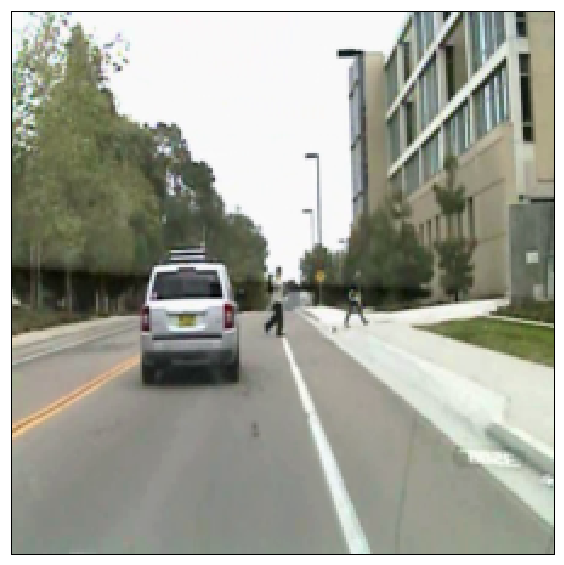

In [3]:
TRAIN_TEST_SPLIT = 0.9

trans = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    #transforms.Normalize(mean=[-1, -1, -1], std=[1, 1, 1]),
    #normalize(0, 255),
])
cwd = os.getcwd()
LISA_dataset = LISACarDataset(cwd + "/data", cwd + "/bbox.txt", trans)


train_size = int(TRAIN_TEST_SPLIT * len(LISA_dataset))
test_size = len(LISA_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(LISA_dataset, [train_size, test_size])

LISA_dataset.visualize(9)

## Import the dataset into a data loader
Similar to the last lab, we need to import our dataset into a data loader object. Keep in mind that you are training two separate branches of a neural network here, and that may affect how you load the data.

In [4]:
BATCH_SIZE = 8
LEARNING_RATE = 0.01
NUM_EPOCHS = 25
SHUFFLE = False

data_loader_train = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=SHUFFLE) 
data_loader_test  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=SHUFFLE) 

## Localization Utility Functions
Here you will need to write all the necessary utility functions to actually accomplish the image localization task. You will definitely need to do some research for this part of the lab, however these are not difficult concepts to understand. 
Specifically, you will need to know how [Intersection over Union (IoU)](https://en.wikipedia.org/wiki/Jaccard_index) works in order to calculate how well your image localizer is doing. The following utility function templates are here to help you do that but please keep in mind there are a lot of ways to do this and you may need more than just the function templates provided. 

In [5]:
# Compute the area of a bounding box
# Input - tuple of size 4 with bounding box coordinates
# Output - The area of a bounding box
def calc_area(box):
    return box[2] * box[3]

# Computes intersection between two boxes
def calc_intersection(box1, box2):
    # overlap = min(x2 values) - max(x1 values)
    shared_x = min(box1[0] + box1[2], box2[0] + box2[2]) - max(box1[0], box2[0])
    shared_y = min(box1[1] + box1[3], box2[1] + box2[3]) - max(box1[1], box2[1])
    if shared_x < 0 or shared_y < 0:
        return 0
    return shared_x * shared_y
    
# Computes union between two boxes
def calc_union(box1, box2):
    return calc_area(box1) + calc_area(box2) - calc_intersection(box1, box2)
    
# Compute the IoU of a box. 
# Input
# boxes1 - bounding box coordinates for one set of images
# boxes2 - bounding box coordinates for another set of images
# Output - The intersection over union between the coordinate lists
def calc_IoU(boxes1, boxes2):
    if len(boxes1) != len(boxes2):
        raise Exception("NEED SAME LENGTH OF BOXES FOR EACH LIST")
    ious = []
    for i in range(0, len(boxes1)):
        ious.append(calc_intersection(boxes1[i], boxes2[i]) * 1.0 / calc_union(boxes1[i], boxes2[i]))
    return ious
  
# Compute the accuracy of the bounding box regressor
# Input
#   predicted - list of models predicted bounding box coordinates
#   grd_truth - ground truth bounding box coordiantes
#   threshold - IoU threshold for a correct prediction
# Output - Accuracy of the model over the current sample
def calc_accuracy(predicted, grd_truth, threshold=0.65):
    if len(predicted) != len(grd_truth):
        raise Exception("NEED SAME LENGTH OF BBOXES TO CALCULATE ACCURACY")
    total = len(predicted)
    num_accept = 0
    result_IoUs = calc_IoU(predicted, grd_truth)
    for iou in result_IoUs:
        if iou >= threshold:
            num_accept = num_accept + 1
    return num_accept * 1.0 / total
    # TODO: USE NUMPY ARRAY TO MAKE THIS FASTER?
    
def calc_accuracy_model(model, data_loader):
    batches = 0
    total_acc = 0.0

    for i, data in enumerate(data_loader, 0):
        x, y_real = data  # get the inputs
        if USE_GPU:
            x = x.cuda()
            y_real = y_real.cuda()

        y_predict = model(x)  # Forward propogation
        batch_accuracy = calc_accuracy(y_predict, y_real)
        total_acc += batch_accuracy
        batches += 1
 
    acc = total_acc / batches
    return acc

##### Debugging

In [6]:
b1 = (0,0,2,2)
b2 = (0.1,0,2,2)
print("IoU:\t", calc_IoU([b1], [b2]))
print("Union:\t", calc_union(b1, b2))
print("Inter:\t", calc_intersection(b1, b2))

IoU:	 [0.9047619047619047]
Union:	 4.2
Inter:	 3.8


## Import the pretrained resnet model
Similar to your lab 2 code, we want to import the resnet18 model. Instead of making our output layer for classification, we will instead change our output layer to predict the bounding box coordinates. Keep in mind, you should not use the same loss function for classification as you would regression. Some good loss functions to use for the bounding box regressor are the L1 and L2 loss. You should try both of these values. 

##### GPU IS AVAILABLE?

In [7]:
USE_GPU = torch.cuda.is_available()
print("GPU AVAILABLE: ", USE_GPU)

GPU AVAILABLE:  True


In [8]:
model_resnet18 = models.resnet18(pretrained=True)
# Freeze all weights
for param in model_resnet18.parameters():
    param.requires_grad = False

# Unfreeze another layer for better accuracy
# Want to just unfreeze a conv layer inside layer4 though
#model_resnet18.layer4.requires_grad = True
#model_resnet18.avgpool.requires_grad = True
# Unfreeze last layer
#model_resnet18.fc.requires_grad = True
for child in model_resnet18.layer4.named_children():
    if child[0] == '1':
        for param in child[1].parameters():
            param.requires_grad = True
            
# Make extra branch -- still on same branch, but treating last 4 nodes a separate layer
# DON'T ACTUALLY NEED TO KEEP THE 1000 ORIGINAL OUTPUT NODES
model_resnet18.fc = Linear(in_features=512, out_features=4, bias=True)

#for param in model_resnet18.parameters():
#    print(param.requires_grad)

if USE_GPU:
    model_resnet18 = model_resnet18.cuda()  # Run on GPU
loss_f_l1 = L1Loss() # L1 loss
loss_f_l2 = MSELoss() # L2 loss
optimizer = SGD(model_resnet18.parameters(), lr=LEARNING_RATE)

#print(model_resnet18)

Similar again to Lab 2, you will need to create a function to train the model. Please note that there is a difference between loss and accuracy. We use the IoU to compute accuracy to get an idea of how the model is doing. This does not however affect how the model is being trained. Keep this in mind when doing the lab. For your own clarity you should print both the loss and the accuracy. If the values of the two do not align then there is likely some issue with your code. 

In [9]:
def train_model(model, loss_func, optimizer, lr_scheduler, data_loader_train, dataset_train, num_epochs=25):
    stamp = time.time()
    best_weights = copy.deepcopy(model.state_dict())
    best_loss = 99999999999999999999
    
    # Loop over the number of epochs
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs - 1) + ": ")
        
        running_loss = 0.0
        total_accuracy = 0.0
        iterations = 0
        
        for i, sample in enumerate(data_loader_train, 0):
            x, y_real = sample  # get the inputs
            if USE_GPU:
                x = x.cuda()
                y_real = y_real.cuda()
                

            optimizer.zero_grad() # zero the parameter gradients
            y_predict = model(x)  # Forward propogation
            loss = loss_func(y_predict, y_real)  # Calculate loss between y_predict and y_real
            loss.backward()   # Back propagation (just calculates the derivatives)
            optimizer.step()  # Use derivatives to step in correct direction
            
            #import IPython;IPython.embed()
            
            # Keep track of stuff
            running_loss += loss.item()
            total_accuracy += calc_accuracy(y_predict, y_real)
            iterations += 1
            
            #print("Acc: ", calc_accuracy(y_predict, y_real))

        ### TODO: Compute loss for whole epoch
        epoch_loss = running_loss * 1.0 / len(dataset_train)
        print("\tLoss: {:.4f}".format(epoch_loss)+ "\t")
        epoch_accuracy = total_accuracy * 1.0 / iterations
        print("\tAccuracy: {:.4f}".format(epoch_accuracy))
        #print("\tAccuracy: {:.4f}".format(calc_accuracy_model(model, data_loader_train))) too slow

        ### TODO: Update best weights if they have the lowest loss ###
        if running_loss < best_loss:
            best_weights = copy.deepcopy(model.state_dict())
            best_loss = running_loss
        
    elapsed = time.time() - stamp
    print("Training complete in {:.0f} min {:.0f} sec".format(elapsed // 60, elapsed % 60))
    
    model.load_state_dict(best_weights)
    return model

In [10]:
best_ft_l1 = train_model(model_resnet18, loss_f_l1, optimizer, lr_scheduler, data_loader_train, train_dataset, NUM_EPOCHS)
best_ft_l2 = train_model(model_resnet18, loss_f_l2, optimizer, lr_scheduler, data_loader_train, train_dataset, NUM_EPOCHS)

Epoch 0/24: 
	Loss: 18.9792	
	Accuracy: 0.0000
Epoch 1/24: 
	Loss: 13.5765	
	Accuracy: 0.0000
Epoch 2/24: 
	Loss: 7.5899	
	Accuracy: 0.0000
Epoch 3/24: 
	Loss: 4.3986	
	Accuracy: 0.0000
Epoch 4/24: 
	Loss: 3.0230	
	Accuracy: 0.0735
Epoch 5/24: 
	Loss: 2.6188	
	Accuracy: 0.1140
Epoch 6/24: 
	Loss: 2.2438	
	Accuracy: 0.1336
Epoch 7/24: 
	Loss: 1.8953	
	Accuracy: 0.1998
Epoch 8/24: 
	Loss: 1.5746	
	Accuracy: 0.2475
Epoch 9/24: 
	Loss: 1.3165	
	Accuracy: 0.3738
Epoch 10/24: 
	Loss: 1.1788	
	Accuracy: 0.4841
Epoch 11/24: 
	Loss: 1.1372	
	Accuracy: 0.4853
Epoch 12/24: 
	Loss: 1.0498	
	Accuracy: 0.5429
Epoch 13/24: 
	Loss: 1.0353	
	Accuracy: 0.5833
Epoch 14/24: 
	Loss: 0.9651	
	Accuracy: 0.6434
Epoch 15/24: 
	Loss: 0.9830	
	Accuracy: 0.6311
Epoch 16/24: 
	Loss: 0.9250	
	Accuracy: 0.6728
Epoch 17/24: 
	Loss: 0.8943	
	Accuracy: 0.6691
Epoch 18/24: 
	Loss: 0.8944	
	Accuracy: 0.6801
Epoch 19/24: 
	Loss: 0.8623	
	Accuracy: 0.6875
Epoch 20/24: 
	Loss: 0.8422	
	Accuracy: 0.7022
Epoch 21/24: 
	Loss: 

### Now see if our model overfit by getting the test accuracy

In [12]:
print("Training accuracy final model l1: ", calc_accuracy_model(best_ft_l1, data_loader_train))
print("Testing accuracy final model l1 : ", calc_accuracy_model(best_ft_l1, data_loader_test))
print("Training accuracy final model l2: ", calc_accuracy_model(best_ft_l2, data_loader_train))
print("Testing accuracy final model l2 : ", calc_accuracy_model(best_ft_l2, data_loader_test))

Training accuracy final model l1:  0.8970588235294118
Testing accuracy final model l1 :  0.78125
Training accuracy final model l2:  0.8970588235294118
Testing accuracy final model l2 :  0.78125
